# Diagnosing Pneumonia from Pediatric Chest X-Rays with Deep Learning

#### [Greg Tozzi](https://www.linkedin.com/in/gregorytozzi/) | May, 2020

*This is a portion of my final group project from the [applied machine learning](https://www.ischool.berkeley.edu/courses/datasci/207) course that I took as part of the UC Berkeley School of Information's [Master of Information and Data Science](https://datascience.berkeley.edu) program.  Deep learning was not an integral part of the course, but we were encouraged to incorporate it into our final project through self-study.*


**Skills demonstrated:** *Deep Learning for Computer Vision* | *Getting and transforming image data* | *Evaluating model performance*

**Languages and frameworks**: *Python* | *NumPy* | *TensorFlow*

## Introduction and Motivation

Pediatric pneumonia is a significant health care challenge in the [developing world](https://pedsinreview.aappublications.org/content/34/10/438).  Pneumonia is [best diagnosed using a chest x-ray](https://www.nhlbi.nih.gov/health-topics/pneumonia), with different forms of the illness presenting [somewhat differently](https://www.med-ed.virginia.edu/courses/rad/cxr/pathology3chest.html) in the images.  The developing world suffers from a lack of radiologists with Liberia, for instance, having [only two as of 2016](https://www.theatlantic.com/health/archive/2016/09/radiology-gap/501803/).  Deep convolutional neural networks (CNNs) have been applied successfully to medical imaging problems.  This project walks through applying an existing CNN architecture to a set of 5,856 anterior-posterior pediatric chest x-rays contributed by [Kermany et al](https://data.mendeley.com/datasets/rscbjbr9sj/2). The data are divided into a training set of 5,232 images and a test set of 624 images.  The images are in a variety of aspect ratios and resolutions.

## The Problem

I'm going to try to detect pneumonia in unseen pediatric chest x-rays using a CNN trained from similar images.  This is a binary classification problem.

## Getting Started

Let's begin by loading a number of useful packages and functions.

In [1]:
# Load packages
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import requests
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Next, download the data.  The data's path was not easily copied from the web site where the files are hosted, but I was able to find it in the site's source.  The data is in a Zip file that weighs in at around 1GB.  The code below will download the Zip file to the current working directory.

In [2]:
if not os.path.exists('chestxray.zip'):
  data_url     = 'https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip'
  data_request = requests.get(data_url)
  zipfile      = open('chestxray.zip', 'wb')
  zipfile.write(data_request.content)
  zipfile.close()

The code below unzips the data to the current working directory.  Note that the data are provided in a file structure ready to be used with Keras' `.flow_from_directory` method.

In [3]:
if not os.path.exists('chest_xray'):
  with ZipFile('chestxray.zip', 'r') as zipObj:
    zipObj.extractall()

## Preparing the Images

This is not a particularly large data set. If we reduce the image resolution to the default expected by our model, the data can fit neatly in memory on most laptops.  Model training and inferencing go a bit faster if we use TensorFlow's `.flow` method rather than `.flow_from_directory`.  Preparing the data for training involves reading the images in in a common resolution and concatenating them into training, validation, and test tensors.  These tensors are 4-dimensional:  height x width x number of images x channels.  Even though these are grayscale images, I'll load them as 3-channel to conform to the model's input dimensions.

I'm going to load and process the data using three nested functions.  The first loads a single image, the second calls the first to load a subset (either normal images or pneumonia images) from a directory, and the third calls the second to load the entire directory.

In [4]:
def load_image(image_path, dim=(224,224)):
  """
  Loads a single image as a Numpy array and resizes it as
  desired.  The default dimensions are consistent with
  those expected by the VGG models.  

  Args:
    image_path: str pointing to the file

    dim: Two-element tuple giving the desired height
         and width of the processed image

  Returns:
    image:  A three-channel Numpy array
    """
  image = cv2.imread(filename=image_path)
  image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
  return image
  
  
def load_subset(directory_path, label):
  """
  Loads a subset (NORMAL or PNEUMONIA) of one of the
  sets (train, test) in the chest x-ray data set.

  Args:
    directory_path: str pointing to the directory
                    containing image files
    
    label: A label to apply to the images in the set.
           Intended to be a 1 or 0, but could be a float,
           str or other data type.
  
  Returns:
    x: 4-dimensional np.array containing images
    y: 1-dimensional np.array containing labels

  """
  # List the files in the directory
  files = os.listdir(directory_path)
  
  # Initialize a list that will contain the images
  output = []

  # Build the list of images
  for file in files:
    if file[-4:] == 'jpeg':
      image_path = os.path.join(directory_path, file)
      output.append(load_image(image_path))
  
  # Convert the images to an np.array
  x = np.array(output)

  # Build the array of labels
  y = np.repeat(label, len(output))
  return (x, y)
  
  
def load_set(set_path):
  """
  Loads a single set (train, test, val) from the 
  chest x-ray data set.

  Args:
    set_path: str giving the path to the directory

  Returns:
    x: 4-dimensional np.array containing images
    y: 1-dimensional np.array containing labels
  """
  # Load normal and pneumonia images and labels
  print('  Loading normal')
  normal_x, normal_y = load_subset(set_path + '/NORMAL', 0)
  print('  Loading pneumonia')
  pneumonia_x, pneumonia_y = load_subset(set_path + '/PNEUMONIA', 1)

  # Concatenate the positive and negative classes
  x = np.concatenate((normal_x, pneumonia_x))
  y = np.concatenate((normal_y, pneumonia_y))
  return (x, y)

Let's use these functions to load the data that we'll use for training and validation first.  This takes some time to complete.

In [5]:
train_validation_x, train_validation_y = load_set('chest_xray/train')

  Loading normal
  Loading pneumonia


It's a good idea at this point to verify that the arrays are of the expected dimensions.

In [6]:
print(train_validation_x.shape, train_validation_y.shape)
# Expected output: (5232, 224, 224, 3) (5232,)

(5232, 224, 224, 3) (5232,)


Now load the test data.

In [7]:
test_x, test_y = load_set('chest_xray/test')

  Loading normal
  Loading pneumonia


In [8]:
print(test_x.shape, test_y.shape)
# Expected output - (624, 224, 224, 3) (624,)

(624, 224, 224, 3) (624,)


Now let's split training and validation data.  [Scikit-Learn's](https://scikit-learn.org/stable/) `test_train_split` function makes this easy.

In [9]:
train_x, validation_x, train_y, validation_y = train_test_split(train_validation_x,
                                                                train_validation_y,
                                                                test_size=0.1,
                                                                random_state=98)

And check the array shapes again.

In [10]:
print(train_x.shape, train_y.shape, validation_x.shape, validation_y.shape)
# Expected output: (4708, 224, 224, 3) (4708,) (524, 224, 224, 3) (524,)

(4708, 224, 224, 3) (4708,) (524, 224, 224, 3) (524,)


## Examining the Data

The data is skewed strongly toward positive examples.  We need to keep this in mind because high accuracy can be achieved on the training set simply by predicting the majority class.


In [11]:
percent_positive = train_y.sum() / len(train_y)
print('Percent of images that are positive - %.3f' %percent_positive)

Percent of images that are positive - 0.743


Let's visualize a handful of positive and negative examples.  The function below plots five images.

In [12]:
def plot_five_images(images):
  """
  As the name implies, plots five images
  in a single row

  Args:
    images: list or np.array containing images

  Returns: None
  """
  # Establish an image index
  pane = 1

  # Instantiate the plot
  fig = plt.figure(figsize=(15,15))

  # Plot the images
  for image in images:
    plt.subplot(1, 5, pane)
    plt.imshow(image)
    plt.axis('off')
    pane += 1
  plt.show()

**Five Positive Examples**

You can see from the five examples of individuals diagnosed with pneumonia that there is variation in brightness, arm position, and the presence or absence of what appears to be medical equipment.

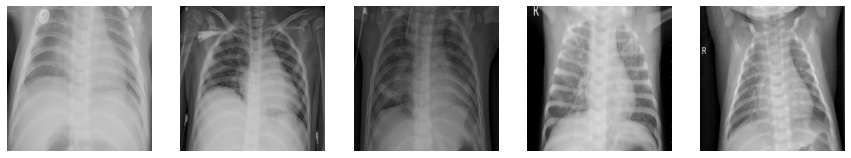

In [13]:
# Extract five training images for individuals diagnosed with pneumonia
positive_training_sample = train_x[train_y == 1][:5]
plot_five_images(positive_training_sample)

**Five Negative Examples**

The negative images appear generally clearer.  Still, my big takeaway from looking over these images is that radiology is a pretty hard.

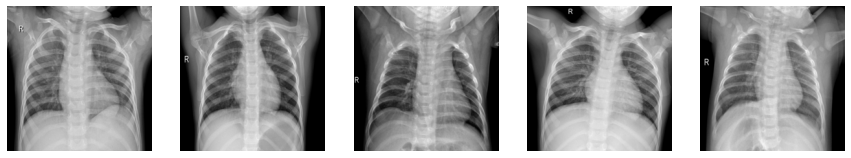

In [14]:
# Extract five training images for individuals diagnosed with pneumonia
negative_training_sample = train_x[train_y == 0][:5]
plot_five_images(negative_training_sample)

## Training the Model

I'm going to train a [VGG16](https://www.robots.ox.ac.uk/~vgg/research/very_deep/) model on the data.  VGG16 was state of the art when it won the ImageNet Large Scale Visual Recognition Competition (ILSVRC) in 2014, but today it's a little dated.

I'll train the model using randomly initialized weights by setting `weights` to `None`.  At first glance, transfer learning seems like an appealing alternative to this approach, but my (admittedly limited) experiments with transfer learning were largely unsatisfying and resulted frequently in the model picking only the majority class.  Since this is a binary classification problem, I'll set the output to a single neuron with a sigmoid activation function.

In [15]:
model = tf.keras.applications.VGG16(include_top=True,
                                    weights=None,
                                    classes=1,
                                    classifier_activation='sigmoid')

I'm using the RMSprop optimizer.  All setting are default with the exception of `learning_rate` which is two orders of magnitude smaller than default.

In [16]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001)

Next, compile the model using [logarithmic loss](http://wiki.fast.ai/index.php/Log_Loss), also referred to as *binary cross-entropy*, as the loss function.

In [17]:
model.compile(optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy'])

### Data Augmentation

The training generator lets you flow augmented data into the model.  Data augmentation involves perturbing the training data to increase the size of the data and reduce overfitting.  [Wang and Perez](https://arxiv.org/pdf/1712.04621.pdf?source=post_page---------------------------) demonstrated the value of applying this approach to image classification.  In this case, I will normalize the pixel values by dividing by 255.  I'll also use horizontal flips, rotations of up to 40 degrees, and other distortions.  Importantly, the validation and test sets only rescale the pixel intensity.  Be careful not to augment your validation and test sets.

In [18]:
batch = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2)
  
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255)
  
train_generator = train_datagen.flow(
    train_x,
    train_y,
    batch_size=batch)
  
validation_generator = validation_datagen.flow(
    validation_x,
    validation_y,
    batch_size=batch)

Plotting the augmented images gives a sense of how the images are manipulated.

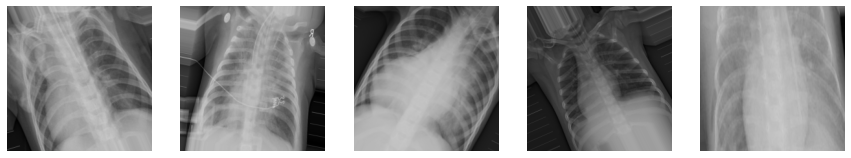

In [19]:
x_batch, y_batch = next(train_generator)
plot_five_images(x_batch[:5])

### Reviewing the Model Architecture

The VGG16 model consists of paired convolutional layers followed by max pooling layers.  Note from the diagram that follows that the model has been modified to return single class sigmoid (i.e. binary) output.  The resulting model has over 134 million trainable parameters.

In [20]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

### Fitting the Model

Precompute the number of steps per epoch.

In [21]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

I'm going to train the model for 20 epochs, reporting training and validation accuracy at the end of each epoch.  I'm not going to use callbacks to force an early stop because I want to show the evolution of accuracy and loss during training later.  If you run this notebook, expect that your results will be different because the weights are randomly initialized.

In [22]:
history = model.fit(
    x=train_generator,
    epochs=30,
    steps_per_epoch=train_steps,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    )

Epoch 1/30
147/147 [==============================] - 47s 322ms/step - loss: 0.5637 - accuracy: 0.7427 - val_loss: 0.5335 - val_accuracy: 0.7305
Epoch 2/30
147/147 [==============================] - 47s 319ms/step - loss: 0.4196 - accuracy: 0.8029 - val_loss: 0.2969 - val_accuracy: 0.8652
Epoch 3/30
147/147 [==============================] - 47s 318ms/step - loss: 0.3221 - accuracy: 0.8556 - val_loss: 0.2825 - val_accuracy: 0.8770
Epoch 4/30
147/147 [==============================] - 47s 318ms/step - loss: 0.2865 - accuracy: 0.8794 - val_loss: 0.3025 - val_accuracy: 0.8848
Epoch 5/30
147/147 [==============================] - 47s 319ms/step - loss: 0.2580 - accuracy: 0.8914 - val_loss: 0.2177 - val_accuracy: 0.9141
Epoch 6/30
147/147 [==============================] - 46s 316ms/step - loss: 0.2360 - accuracy: 0.9065 - val_loss: 0.3313 - val_accuracy: 0.8574
Epoch 7/30
147/147 [==============================] - 46s 315ms/step - loss: 0.2065 - accuracy: 0.9153 - val_loss: 0.1688 - val_ac

#### Visualizing Convergence

Training losses converge smoothly toward an asymptotic lower limit.  Validation loss decreases in a similar manner but with a few large excursions that may be cause for concern.

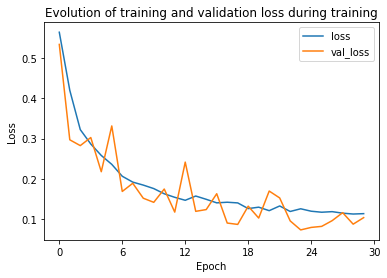

In [23]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of training and validation loss during training')
plt.show()

Similarly, training accuracy increases smoothly toward an asymptotic upper limit.  Validation accuracy follows but with some excursions.

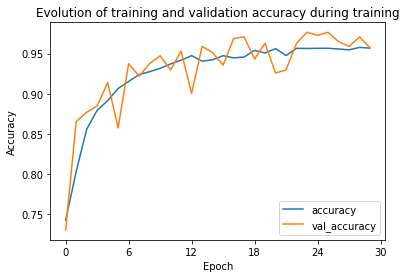

In [24]:
ax = history_df.plot(y=['accuracy', 'val_accuracy'],
                xticks=np.linspace(0, len(history_df), 6),
                title='Evolution of training and validation accuracy during training')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.show()

## Evaluating the Model

We should not be satisfied with the model's performance until we check it against a previously-unseen test set.  The function below produces an evaluation report borrowing some of the better evaluation pieces of Scikit-Learn and [mlxtend](http://rasbt.github.io/mlxtend/).

In [25]:
def evaluate_model(model, test_x, test_y, threshold=0.5):
  """
  Applies a series of evaluation tools to generate
  a report of the model's performance.

  Args:
    model: tensorflow.python.keras.engine.training.Model
           instance trained on data

    test_x: np.array representing the test set

    test_y: np.array of test labels

    threshold: float giving the binary prediction threshold

  Returns:
    None, but displays evaluation output
  """

  # Predict from the test set
  y_probs = model.predict(x=test_x)
  y_probs = y_probs.reshape((len(y_probs),))

  # Convert to binary probabilities
  y_hat   = y_probs > threshold
  y_hat   = y_hat.reshape(len(y_hat),)

  # Plot the confusion matrix
  print('----------------------Confusion Matrix---------------------\n')
  conf_mat = confusion_matrix(test_y, y_hat)
  fig, ax = plot_confusion_matrix(conf_mat)
  plt.show()

  # Print the classification report
  print('\n\n-----------------Classification Report-----------------\n')
  print(classification_report(test_y, y_hat))

  # Display the ROC curve
  print('\n\n-----------------------ROC Curve-----------------------\n')
  fpr, tpr, thresholds = roc_curve(test_y, y_probs)
  roc_auc = roc_auc_score(test_y, y_probs)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show()

  # Find misclassified images and present them
  actually_pos_pred_neg = np.logical_and(test_y == 1, y_hat == 0)
  actually_neg_pred_pos = np.logical_and(test_y == 0, y_hat == 1)

  print('\n\n-----------Positive Images Predicted Negative----------\n')
  plot_five_images(test_x[actually_pos_pred_neg][:5])

  print('\n\n----------Negative Images Predicted Positive-----------\n')
  plot_five_images(test_x[actually_neg_pred_pos][:5])

Calling the function produces a nicely-formatted report. The model's overall performance is good enough to be interesting. The confusion matrix and precision and recall values indicate that the model's performance is reasonably well balanced, though the model does tilt toward over-predicting positive cases. This is most clearly seen in the relatively high precision and relatively low recall associated with the negative class.

----------------------Confusion Matrix---------------------



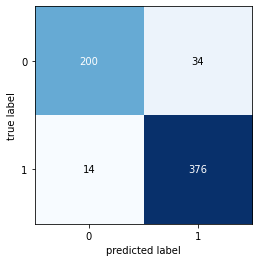



-----------------Classification Report-----------------

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       234
           1       0.92      0.96      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624



-----------------------ROC Curve-----------------------



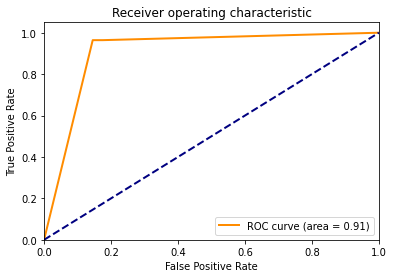



-----------Positive Images Predicted Negative----------



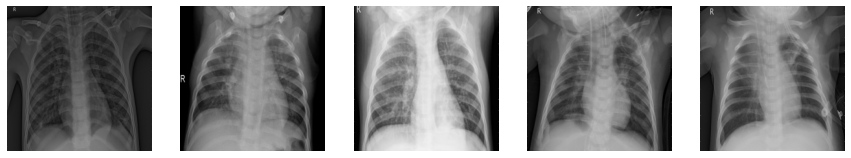



----------Negative Images Predicted Positive-----------



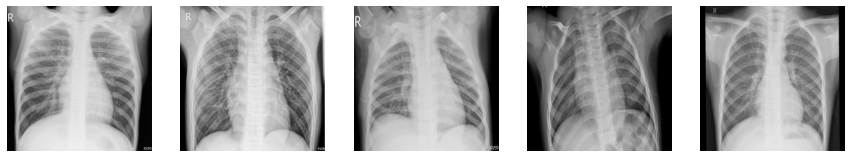

In [26]:
evaluate_model(model, test_x, test_y)

## Intermediate Activations

Looking at intermediate activations give some sense of what is going on inside the model. CNNs build layers of filters that detect certain features in an image. The functions below run a single image forward through the network and visualize the activations associated with each filter in a specified layer.

In [27]:
def intermediate_activations(model):
  """
  Given a model, generates a model suitable
  for visualizing activations.

  Args:
    model: tensorflow.python.keras.engine.training.Model
           instance

    last_layer: int giving the final layer to be rolled
                into the new model
  
  Returns:
    activation_model: tensorflow.python.keras.engine.training.Model
                      instance
  """
  # Pull out the layers of interest.  These should be all of the
  # convolutional and max pooling layers and the layers feeding them.
  # There is no need to include dense layers at the end of the model.
  layer_outputs = [layer.output for layer in model.layers]

  # Build the new activation model.  The sample code we referenced drew from
  # the Keras package rather than the keras API in the TensorFlow package.
  # The former throws an error under TensorFlow 2.0.
  activation_model = tf.keras.models.Model(inputs=model.input,
                                           outputs=layer_outputs)
  
  return activation_model

In [28]:
def visualize_layer(activation_layer):
  """
  Visualizes a single activation layer created by
  applying the .predict method to an activation_model.

  Args:
    activation_layer: np.array

  Returns:
    None
  """
  # Count the filters
  filters = activation_layer.shape[3]

  # Create a plot
  plt.figure(figsize=(15,np.ceil(15/8 * filters //8)))

  # I use `pane` to scroll through the matplotlib matrix
  pane = 1

  # Set the color map to reversed greyscale
  plt.rc('image', cmap='gray_r')
    
  # Genrate the subplots
  for i in range(filters):
    plt.subplot(np.ceil(filters/8), 8, pane)
    plt.imshow(activation_layer[0,:,:,i])
    plt.axis('off')
    pane += 1
  plt.show()

In [29]:
def visualize_intermediate_activations(model, image, layers):
  """
  Given a model and an image, visualizes intermediate
  activations.

  Args:
    model: tensorflow.python.keras.engine.training.Model
           instance

    last_layer: int giving the final layer to be rolled
                into the new model

    image: np.array in three dimensions (x, y, channel)

    layers: list of indicies for which to plot activations
  
  Returns:
    None, but displays a bunch of activations.
  """
  # Build the activation model
  activation_model = intermediate_activations(model)

  # The predict method requires 4D input
  image = image / 255
  image = image.reshape(1, image.shape[0],
                        image.shape[1], image.shape[2])
  
  # Predict on the image
  activations = activation_model.predict(image)

  # Display activations
  for layer in layers:
    visualize_layer(activations[layer])

**Visualize activations for the first convolutional layer**.  The first layer already shows signs of developing edge detection.  Note that in the images below, black indicates strong activation.

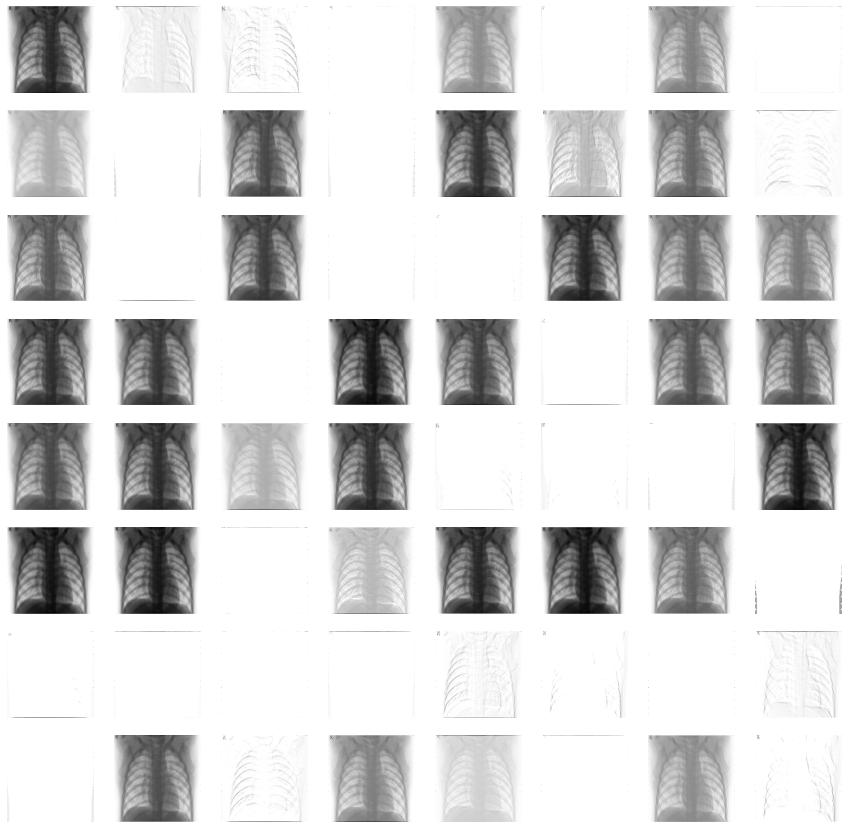

In [30]:
positive_index = np.where(test_y == 1)
positive_image = test_x[positive_index[0][0]]
visualize_intermediate_activations(model, positive_image, [1])

**Visualize activations for the 11th convolutional layer**.  The resolution of the intermediate activation images in this layer are much lower than in the first layer due to the max pooling layers.  The filters produce a more diverse set of results, however, that activate on a wider variety of features in the image.

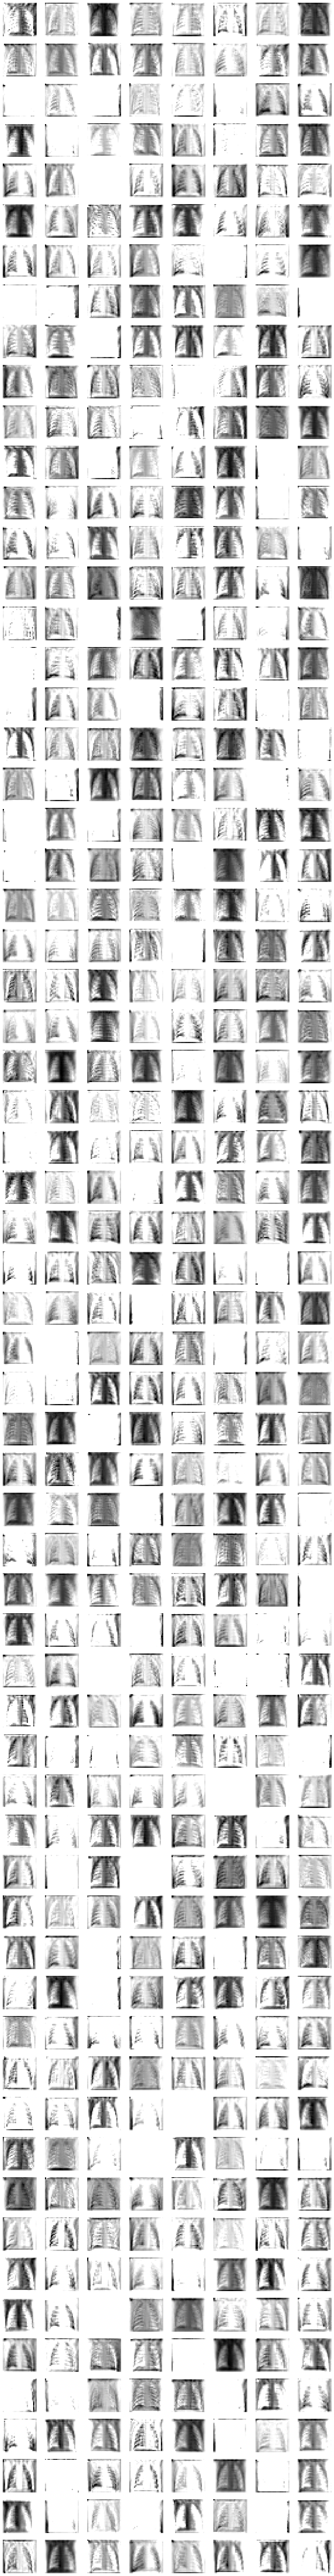

In [31]:
visualize_intermediate_activations(model, positive_image, [11])

## Conclusion

My model performs fairly well but lags the state-of-the art.  Still, it's tremendously satisfying to see a simple model make substantial headway on learning a difficult task.  Good next steps would include an investigation of alternative model architectures, more robust hyperparameter optimization, and investigating transfer learning using models trained on similar images.